### Clone repository, download models and data, install necessary packages

In [1]:
!git clone -q https://github.com/saic-vul/fbrs_interactive_segmentation

URL_PREFIX = "https://github.com/saic-vul/fbrs_interactive_segmentation/releases/download/v1.0"
DATA_FOLDER = "./fbrs_interactive_segmentation/datasets" 
WEIGHTS_FOLDER = "./fbrs_interactive_segmentation/weights"

!mkdir -p {DATA_FOLDER}
!mkdir -p {WEIGHTS_FOLDER}

# CHOOSE MODEL HERE
# possible choices are: hrnet18_ocr64_sbd, hrnet32_ocr128_lvis, hrnet32_ocr128_sbd,
# resnet101_dh256_sbd, resnet34_dh128_sbd, resnet50_dh128_lvis, resnet50_dh128_sbd
MODEL_NAME = "resnet34_dh128_sbd"
WEIGHTS_URL = f"{URL_PREFIX}/{MODEL_NAME}.pth"
!wget -q -P {WEIGHTS_FOLDER} {WEIGHTS_URL}

for dataset in ['GrabCut', 'Berkeley', 'DAVIS']:
  dataset_url = f"{URL_PREFIX}/{dataset}.zip"
  dataset_path = f"{DATA_FOLDER}/{dataset}.zip"
  !wget -q -O {dataset_path} {dataset_url}
  !unzip -q {dataset_path} -d {DATA_FOLDER}
  !rm {dataset_path}

!pip3 install -q -r ./fbrs_interactive_segmentation/requirements.txt
%cd fbrs_interactive_segmentation/

     |████████████████████████████████| 37.6MB 76kB/s 
     |████████████████████████████████| 112kB 68.2MB/s 
/content/fbrs_interactive_segmentation


### Imports

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import torch
import numpy as np

sys.path.insert(0, './')

from isegm.utils import vis, exp
from isegm.inference import utils
from isegm.inference.evaluation import evaluate_dataset, evaluate_sample

device = torch.device('cuda:0')
cfg = exp.load_config_file('./config.yml', return_edict=True)

### Init dataset

In [10]:
# Possible choices: 'GrabCut', 'Berkeley', 'DAVIS', 'COCO_MVal', 'SBD'
DATASET = 'GrabCut'
dataset = utils.get_dataset(DATASET, cfg)

### Init model

In [11]:
from isegm.inference.predictors import get_predictor

EVAL_MAX_CLICKS = 20
MODEL_THRESH = 0.49

checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, MODEL_NAME)
model = utils.load_is_model(checkpoint_path, device)

# Possible choices: 'NoBRS', 'f-BRS-A', 'f-BRS-B', 'f-BRS-C', 'RGB-BRS', 'DistMap-BRS'
brs_mode = 'f-BRS-B'
predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH)

### Dataset evaluation

In [12]:
TARGET_IOU = 0.9

all_ious, elapsed_time = evaluate_dataset(dataset, predictor, pred_thr=MODEL_THRESH, 
                                          max_iou_thr=TARGET_IOU, max_clicks=EVAL_MAX_CLICKS)
mean_spc, mean_spi = utils.get_time_metrics(all_ious, elapsed_time)
noc_list, over_max_list = utils.compute_noc_metric(all_ious,
                                                   iou_thrs=[0.8, 0.85, 0.9],
                                                   max_clicks=EVAL_MAX_CLICKS)

header, table_row = utils.get_results_table(noc_list, over_max_list, brs_mode, DATASET,
                                            mean_spc, elapsed_time, EVAL_MAX_CLICKS)
print(header)
print(table_row)

-----------------------------------------------------------------------------------------------
|  BRS Type   |  Dataset  | NoC@80% | NoC@85% | NoC@90% |>=20@85% |>=20@90% | SPC,s |  Time   |
-----------------------------------------------------------------------------------------------
|    NoBRS    |  GrabCut  |  2.10   |  2.44   |  3.18   |    2    |    3    | 0.095 | 0:00:15 |


### Single sample eval

[0.7923468  0.8854471  0.89824456 0.92122626 0.93558127 0.9379461
 0.939819   0.9101192  0.9484723  0.9423743  0.95529073]


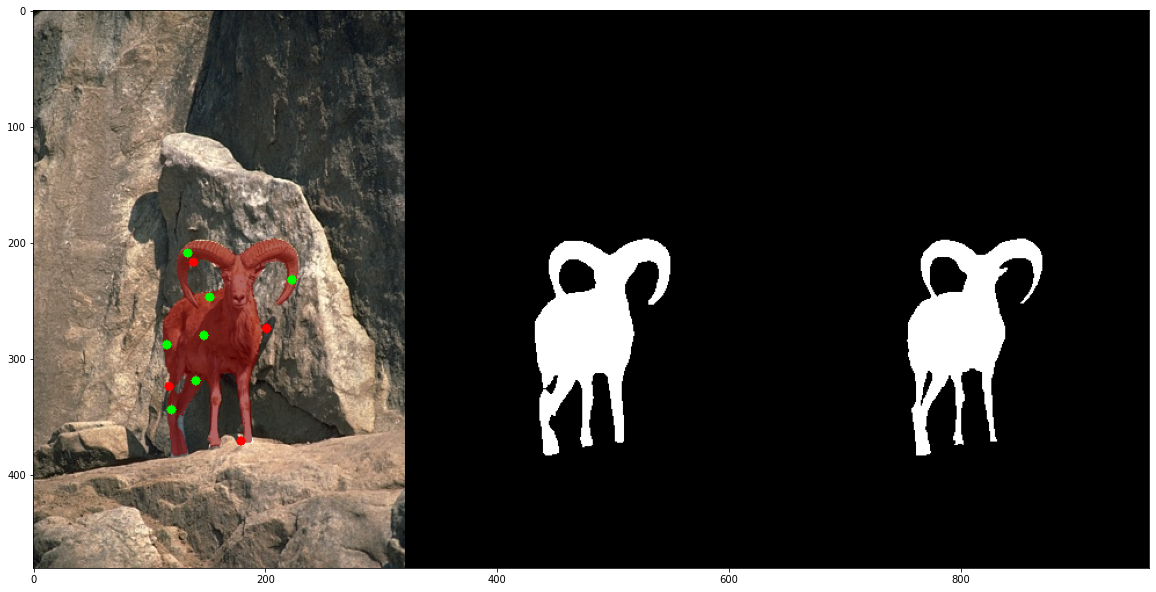

In [26]:
sample_id = 12
TARGET_IOU = 0.95

sample = dataset.get_sample(sample_id)
gt_mask = sample['instances_mask']
image = dataset[sample_id]['images']

clicks_list, ious_arr, pred = evaluate_sample(image, gt_mask, predictor, 
                                              pred_thr=MODEL_THRESH, 
                                              max_iou_thr=TARGET_IOU, max_clicks=EVAL_MAX_CLICKS)

pred_mask = pred > MODEL_THRESH
draw = vis.draw_with_blend_and_clicks(sample['image'], mask=pred_mask, clicks_list=clicks_list)
draw = np.concatenate((draw,
    255 * pred_mask[:, :, np.newaxis].repeat(3, axis=2),
    255 * (gt_mask > 0)[:, :, np.newaxis].repeat(3, axis=2)
), axis=1)

print(ious_arr)

plt.figure(figsize=(20, 30))
plt.imshow(draw)
plt.show()